In [127]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 03A-Pizza-Steak-Image-Classification

## Introduction to CNN and Computer Vision with Tensorflow

**Note**: 

* You can use CNNs for image data as well as text data. CNNs exploit local relationships very well.
* An image has patterns which are very well spatially correlated on a local scale (i.e. we don't have per pixel patterns, rather they span in a spatial location with a definite structure)
* So if a sentence has a structure which is influenced more by local nearby relationships (in context of the NLP problem), CNNs will work really well.

**Examples**
* Simple image classification, whether a picture of a food contains pizza or a steak
* Detect whether or not an object appears in an image (i.e. did a specific car pass through the security cameras)

**Steps**
* Getting the dataset. 
    * Where to keep/host large datasets in case > gdrive storage. 
    * Dataset fetching scripts
    * Common dataset sources for different kinds of problems
    * Version controlling or putting dataset in a remote repo : `dvc`
* Preparing the dataset
    * Making sure it's the right size.
    * Dataset directory structure/Creating a CustomDataset Class
    * Augmentation techniques
    * Noise removal
    * Batch Data Loader, prefetching (Important for large datasets)
* Creating a baseline model 
* Experimenting with large models (on small training subset)
* Fitting and monitoring the training (TensorBoard, Weights & Biases)
* Visualizing the predictions
* Evaluating the model
* Improving the model
* Comparing the models
* Making a prediction with the trained model

## `ClassicImageDatasetDirectory`

* Two folders with train and test images
* Each of train and test contain subfolders with class_names
* Each class_names folder contains images 

In [192]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.image import ClassicImageDataDirectory

In [193]:
data_dir = '../data/pizza_steak/'
subsets = ['train', 'test']
class_names = ['pizza', 'steak']

In [195]:
imgdir = ClassicImageDataDirectory(data_dir, target_image_size=(224, 224), dtype=np.uint8)

### Class Names

In [196]:
imgdir.class_names, imgdir.class_labels

(('pizza', 'steak'), (0, 1))

### Counts

In [197]:
imgdir.labelcountdf

,label,name,count_train,count_test
0,0,pizza,750,250
1,1,steak,750,250


We have 750 images each in the train set and 250 images each in the test set for both the classes.

<AxesSubplot:title={'center':'Train vs Test label distribution'}, xlabel='name'>

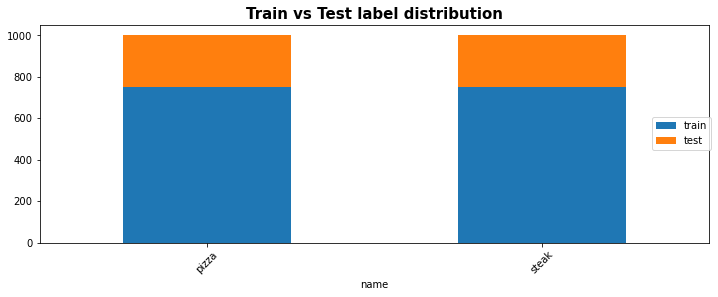

In [198]:
imgdir.plot_labelcounts()

## Load a Batch 

In [199]:
datagen = imgdir.load(32)
batch = next(datagen)

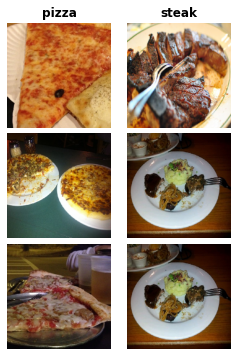

In [201]:
batch.view_random_images(class_names='all', n_each=3);

## A (typical) architecture of a convolutional neural network

Convolutional neural networks are no different to other kinds of deep learning neural networks in the fact they can be created in many different ways. What you see below are some components you'd expect to find in a traditional CNN.

Components of a convolutional neural network:


| **Hyperparameter/Layer type** | **What does it do?** | **Typical values** |
| ----- | ----- | ----- |
| Input image(s) | Target images you'd like to discover patterns in| Whatever you can take a photo (or video) of |
| Input layer | Takes in target images and preprocesses them for further layers | `input_shape = [batch_size, image_height, image_width, color_channels]` |
| Convolution layer | Extracts/learns the most important features from target images | Multiple, can create with [`tf.keras.layers.ConvXD`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (X can be multiple values) |
| Hidden activation | Adds non-linearity to learned features (non-straight lines) | Usually ReLU ([`tf.keras.activations.relu`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)) |
| Pooling layer | Reduces the dimensionality of learned image features | Average ([`tf.keras.layers.AvgPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)) or Max ([`tf.keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) |
| Fully connected layer | Further refines learned features from convolution layers | [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) |
| Output layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 3 for pizza, steak or sushi)|
| Output activation | Adds non-linearities to output layer | [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) (binary classification) or [`tf.keras.activations.softmax`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) |


How they stack together:

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-simple-convnet.png)
*A simple example of how you might stack together the above layers into a convolutional neural network. Note the convolutional and pooling layers can often be arranged and rearranged into many different formations.*

# An end-to-end example

Classes: `pizza`, `steak`

* 750 training examples for each class
* 250 test examples for each class

[Original author's paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) used RandomForest for establishing the baseline accuracy of 50.76%

> **Note**: A baseline is a score or en evaluation metric which is based on the performance of a relatively simple model on the dataset. Any model we build should atleast outperform the baseline

In [230]:
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers

## Basic structure of a convolution neural network 

* The "`2D`" means our inputs are two dimensional (height and width), even though they have 3 colour channels, the convolutions are run as a 2D kernel with depth and output is 2D.
* `filters` - these are the number of "feature extractors" that will be moving over our images.
* `kernel_size` - the size of our filters, for example, a `kernel_size` of `(3, 3)` (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.
* `stride` - the number of pixels a `filter` will move across as it covers the image. A `stride` of 1 means the filter moves across each pixel 1 by 1. A `stride` of 2 means it moves 2 pixels at a time.
* `padding` - this can be either `'same'` or `'valid'`, `'same'` adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as `'valid'` (default) cuts off excess pixels where the `filter` doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.


What is a **feature**?

* Neural networks are automatic feature extractors. They "learn" features, and the weights + the mechanism of matrix multiplication and non-linearity (and other specifics) is called feature extractor. 
* We can handcraft features for an image. For example, for a pizza, the presence of a circular shape is important. But given an arbitrary image, how do we identify the presence of a circular feature? Neural networks learn this and hopefully some of the neurons get highly activated when they see a circular shape in the image.
* So basically combining features: f1: circular shape, f2: red patches of circular inside a circle (pepporini), etc etc many non-tangible features lead the network to predict in favour of a pizza.

### `Conv2D` over images


* Whether the image has depth or not, the output will still have depth = 1 (for one kernel output)
* Number of filters decide the output depth
* When the image has depth, the applied kernel is (3, 3, depth)
    * and hence has that many more parameters    
* The bias is shared accross the depth in case a depth kernel is applied
* A padding of *same* in convolution means enough padding to make the input size same as the output size after convolution

### Convolution over depth channels

In [172]:
model_1channel = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 1)),
    layers.Conv2D(filters=1, kernel_size=3)
])

model_1channel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 1)       10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [173]:
model_1channel.input_shape, model_1channel.output_shape

((None, 224, 224, 1), (None, 222, 222, 1))

In [174]:
model_3channel = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(filters=1, kernel_size=3)
])

model_3channel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 1)       28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [176]:
model_3channel.input_shape, model_3channel.output_shape

((None, 224, 224, 3), (None, 222, 222, 1))

### `same` padding

In [180]:
model_ = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(filters=1, kernel_size=3, padding='same')
])
model.input_shape, model.output_shape

((None, 224, 224, 3), (None, 224, 224, 1))

### Multiple filters

* Each filter learns a specific feature from the same kind of input. (This is very similar to attention heads in a transformer)

In [177]:
model_3channel_multifilters = tf.keras.models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(filters=10, kernel_size=3)
])

model_3channel_multifilters.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
Total params: 280
Trainable params: 280
Non-trainable params: 0
_________________________________________________________________


In [178]:
model_3channel_multifilters.input_shape, model_3channel_multifilters.output_shape

((None, 224, 224, 3), (None, 222, 222, 10))

## Pooling

**Note**:

* A padding value of *same* will pad enough zeros on boundaries of the input to make pooling operation move with an equal stride as the kernel size.
    * This results in an output size = $(I+ 2p)/K$
    * E.g. input = 3, kernel_size = 2, padding = 0.5 (1 on any of the side; left or right). output = 2
    * [Padding in Pooling](https://datascience.stackexchange.com/questions/67334/whats-the-purpose-of-padding-with-maxpooling#:~:text=The%20whole%20purpose%20of%20pooling,is%20often%20for%20convolutional%20layers.)
* A common pattern in CNN is to have *same* padding for convolution to retain the same size of the input and then half the size (reduce the dimensionality) of the output by using Pooling (`MaxPool`, `AvgPool` -> Find the most relevant features, denoising) by using a stride of 2, kernel_size 2.
    * Reduces the dimensionality
    * Finds most important patterns
    * Denoising
    * As a side note: stride, kernel_size, dilated convolutions
* Pooling is a fixed operation, while convolutions can be learned. 

[Stackoverflow: Valid vs Same](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t)


* `"VALID"` = without padding:

    ```
    inputs:         1  2  3  4  5  6  7  8  9  10 11 (12 13)
                      |________________|                dropped
                                     |_________________|
    ```

* `"SAME"` = with zero padding:

    ```
                   pad|                                      |pad
       inputs:      0 |1  2  3  4  5  6  7  8  9  10 11 12 13|0  0
                   |________________|
                                  |_________________|
                                                 |________________|
    ```

In [183]:
model_pool_validpad = tf.keras.Sequential([
    layers.Input(shape=(9, 9, 3)),
    layers.MaxPool2D(pool_size=4, padding='valid')
])

model_pool_validpad.input_shape, model_pool_validpad.output_shape

((None, 9, 9, 3), (None, 2, 2, 3))

The 9th input is dropped here with padding = `valid`.

In [185]:
model_pool_samepad = tf.keras.Sequential([
    layers.Input(shape=(9, 9, 3)),
    layers.MaxPool2D(pool_size=4, padding='same')
])

model_pool_samepad.input_shape, model_pool_samepad.output_shape

((None, 9, 9, 3), (None, 3, 3, 3))

The input is padding with 3 extra zeros (2 on one side, 1 on other), so that the pooling operation can move with stride = kernel_size 

## CNN pattern of `same` padding convolution layer, followed by halving the size with pooling

In [187]:
from src.visualize import plot_keras_model

In [186]:
model = tf.keras.models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2, padding='same'),
    layers.Conv2D(5, 3, activation='relu', padding='same'),
    layers.MaxPool2D(2, padding='same'),
    layers.Conv2D(1, 3, activation='relu', padding='same'),
    layers.MaxPool2D(2, padding='same'),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='Adam')

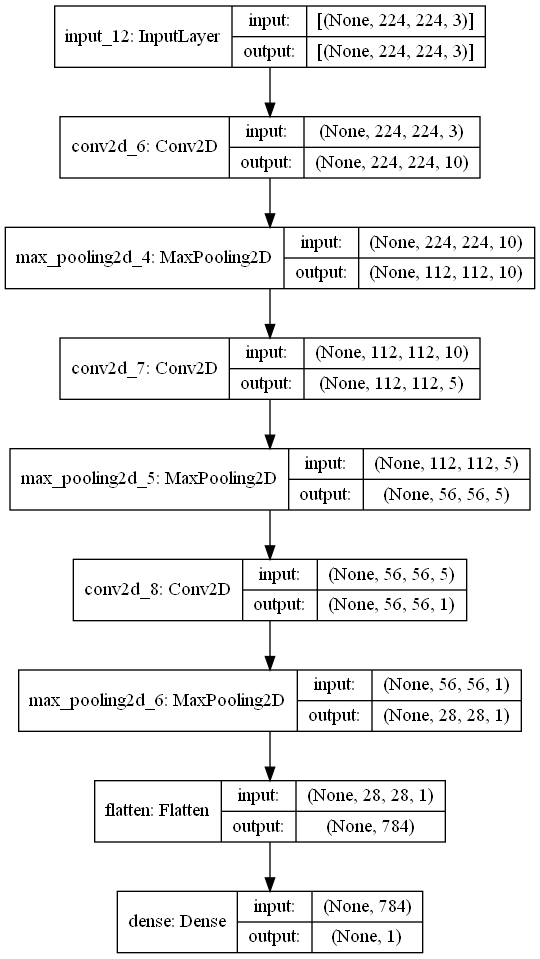

In [189]:
plot_keras_model(model, show_shapes=True)

## Reimplementing a VGG like architecture ([TinyVGG](https://poloclub.github.io/cnn-explainer/))

## Model 1: TinyVGG

In [225]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 42
IMAGE_DIM = (224, 224)
NUM_CHANNELS = 3
INPUT_SHAPE = (*IMAGE_DIM, NUM_CHANNELS)

# Set the seed
tf.random.set_seed(SEED)

### Preprocess the data

- [Train and validation split in ImageDataGenerator](https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator)

In [251]:
train_datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1/255.0)

### Setup the train and test data directories


In [252]:
train_dir = imgdir.train['dir']
test_dir = imgdir.test['dir']

### Import the data from directories and turn it into batches

In [254]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=IMAGE_DIM,
                                               class_mode='binary',
                                               subset='training',
                                               seed=SEED)


validation_data = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=IMAGE_DIM,
                                                    class_mode='binary',
                                                    subset='validation',
                                                    seed=SEED)

test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size=32,
                                             target_size=IMAGE_DIM,
                                             class_mode='binary',
                                             seed=SEED)


Found 1200 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Create the model

In [273]:
from src.evaluate import KerasMetrics
from src.visualize import plot_learning_curve
from sklearn import metrics


In [374]:
# Create the CNN model
model = tf.keras.models.Sequential([
    layers.Input(shape=INPUT_SHAPE),
    layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPool2D(pool_size=2, padding='same'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPool2D(2, padding='same'),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
], name='TinyVGG')

# Compile
model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=[KerasMetrics.f1, 'accuracy'])

# Summary
model.summary()

Model: "TinyVGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 28090)             0   

### Fit the model!

In [375]:
history = model.fit(train_data, epochs=10, steps_per_epoch=len(train_data),
                    validation_data=validation_data, validation_steps=len(validation_data))

tfmodels[model.name] = model

Epoch 1/10
38/38 [==============================] - 8s 195ms/step - loss: 0.6502 - f1: 0.5082 - accuracy: 0.6108 - val_loss: 0.5315 - val_f1: 0.6969 - val_accuracy: 0.7467
Epoch 2/10
38/38 [==============================] - 7s 185ms/step - loss: 0.4519 - f1: 0.7812 - accuracy: 0.7984 - val_loss: 0.5437 - val_f1: 0.7409 - val_accuracy: 0.7800
Epoch 3/10
38/38 [==============================] - 13s 335ms/step - loss: 0.3740 - f1: 0.8406 - accuracy: 0.8443 - val_loss: 0.4879 - val_f1: 0.7311 - val_accuracy: 0.7733
Epoch 4/10
38/38 [==============================] - 11s 298ms/step - loss: 0.2939 - f1: 0.8733 - accuracy: 0.8798 - val_loss: 0.4795 - val_f1: 0.7629 - val_accuracy: 0.8000
Epoch 5/10
38/38 [==============================] - 12s 310ms/step - loss: 0.2926 - f1: 0.8803 - accuracy: 0.8835 - val_loss: 0.4757 - val_f1: 0.7795 - val_accuracy: 0.7733
Epoch 6/10
38/38 [==============================] - 10s 273ms/step - loss: 0.2430 - f1: 0.9069 - accuracy: 0.9113 - val_loss: 0.5063 - va

### Learning Curve

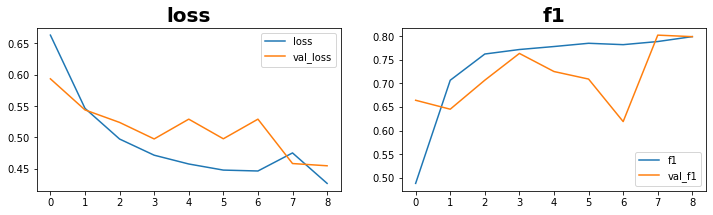

In [391]:
plot_learning_curve(model.history.history, extra_metric='f1');

### Prediction evaluation

In [392]:
y_test_preds_prob = model.predict(test_data)
y_test_preds = y_test_preds_prob.round().flatten()

In [393]:
metrics.accuracy_score(y_test_preds, test_data.labels)

0.514

## Model 2: TinyVGG with Data Augmentation

In [394]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 42
IMAGE_DIM = (224, 224)
NUM_CHANNELS = 3
INPUT_SHAPE = (*IMAGE_DIM, NUM_CHANNELS)

### Preprocess the data (Augmentation)

In [395]:
# Train: Augmented 
train_datagen_aug = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=0.2, # rotate the image slightly
    shear_range=0.2, # shear the image
    zoom_range=0.2, # zoom into the image
    width_shift_range=0.2, # shift the image width ways
    height_shift_range=0.2, # shift the image height ways
    horizontal_flip=True, # flip the image on the horizontal axis
    validation_split=0.2)


# Train: Create another with no augmentation just scaling
train_datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

# Test datagen (No augmentation)
test_datagen = ImageDataGenerator(rescale=1/255.0)


### Setup the train and test directories

In [396]:
train_dir = imgdir.train['dir']
test_dir = imgdir.test['dir']

### Import the data from directories and turn it into batches

In [403]:
train_data_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=IMAGE_DIM,
    class_mode='binary',
    subset='training',
    seed=SEED)

validation_data = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=IMAGE_DIM,
    class_mode='binary',
    subset='validation',
    seed=SEED)

train_data = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=IMAGE_DIM,
    class_mode='binary',
    subset='training',
    seed=SEED)


test_data = test_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=IMAGE_DIM,
    class_mode='binary',
    seed=SEED)


Found 1200 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Compare Normal and Augmented image

In [398]:
images, label = train_data.next()
images_aug, label_aug = train_data_aug.next() # label_aug is same as label

In [399]:
from matplotlib.gridspec import GridSpec

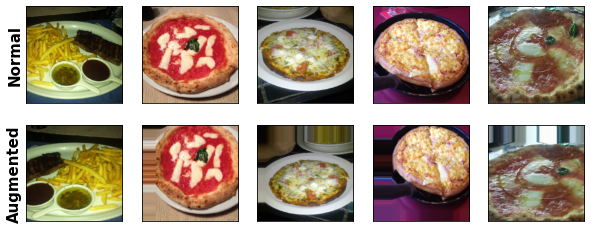

In [400]:
n_each = 5
fig = plt.figure(figsize=(n_each*2, 2*2))
gs = GridSpec(2, n_each)

k = 0
for i in range(5):
    for j, img in zip(range(2), [images[k], images_aug[k]]):
        ax = plt.subplot(gs[j, i])
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.imshow(img)        
        k += 1
        
plt.subplot(gs[0, 0]).set_ylabel('Normal', fontdict=dict(weight='bold', size=15))
plt.subplot(gs[1, 0]).set_ylabel('Augmented', fontdict=dict(weight='bold', size=15));

### Create the model

* Just for practice, I will write it again. Although you can just clone the model as follows:

```python
# clone
tf.keras.models.clone_model(model)

# recompile
model.compile(...)
```

In [401]:
# Set seed
tf.random.set_seed(SEED)

# Create the model
model = tf.keras.models.Sequential([
    layers.Input(shape=INPUT_SHAPE),
    layers.Conv2D(10, 3, activation='relu'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPool2D(2, padding='same'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPool2D(2, padding='same'),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
], name='TinyVGG-data-augment')

# Compile the model
model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam(), metrics=[KerasMetrics.f1, 'accuracy'])

# Summary
model.summary()

Model: "TinyVGG-data-augment"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 28090)    

### Fit the model

In [402]:
history = model.fit(train_data_aug, epochs=10, steps_per_epoch=len(train_data_aug),
                    validation_data=validation_data, validation_steps=len(validation_data))

tfmodels[model.name] = model

Epoch 1/10
38/38 [==============================] - 27s 693ms/step - loss: 0.6354 - f1: 0.4465 - accuracy: 0.6290 - val_loss: 0.5439 - val_f1: 0.6942 - val_accuracy: 0.7400
Epoch 2/10
38/38 [==============================] - 27s 705ms/step - loss: 0.5099 - f1: 0.7235 - accuracy: 0.7541 - val_loss: 0.5087 - val_f1: 0.7389 - val_accuracy: 0.7567
Epoch 3/10
38/38 [==============================] - 24s 646ms/step - loss: 0.4978 - f1: 0.7581 - accuracy: 0.7550 - val_loss: 0.4711 - val_f1: 0.7541 - val_accuracy: 0.7767
Epoch 4/10
38/38 [==============================] - 24s 639ms/step - loss: 0.4692 - f1: 0.7717 - accuracy: 0.7743 - val_loss: 0.4976 - val_f1: 0.7517 - val_accuracy: 0.7833
Epoch 5/10
38/38 [==============================] - 24s 632ms/step - loss: 0.4524 - f1: 0.8116 - accuracy: 0.8098 - val_loss: 0.4827 - val_f1: 0.7443 - val_accuracy: 0.7800
Epoch 6/10
38/38 [==============================] - 24s 640ms/step - loss: 0.4479 - f1: 0.7728 - accuracy: 0.7975 - val_loss: 0.4630 - 

### Learning Curve

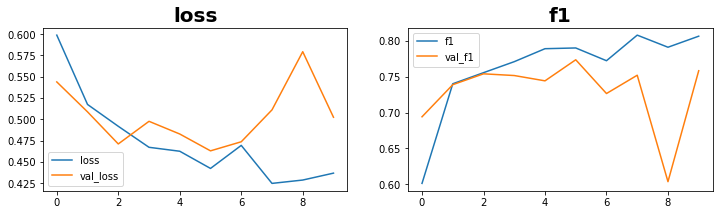

In [406]:
plot_learning_curve(history.history, extra_metric='f1');

### Prediction Evaluatiom

In [408]:
y_test_pred_prob = model.predict(test_data)
y_test_pred = y_test_pred_prob.round().flatten()

metrics.accuracy_score(test_data.labels, y_test_pred)

0.484